In [27]:
!pip install shap

import shap 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.metrics import *
from sklearn.svm import SVC

from google.colab import drive
from pprint import pprint


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Set-up**
- train and test data

In [28]:
drive.mount('/content/drive', force_remount=True)
X_train = pd.read_csv('/content/drive/My Drive/BT4012/processed dataset/v4/X_train.csv')
X_test = pd.read_csv('/content/drive/My Drive/BT4012/processed dataset/v4/X_test.csv')
y_train = pd.read_csv('/content/drive/My Drive/BT4012/processed dataset/v4/y_train.csv')
y_test = pd.read_csv('/content/drive/My Drive/BT4012/processed dataset/v4/y_test.csv')

# Drop unnamed columns
X_train = X_train.drop(columns=['Unnamed: 0'])
X_test = X_test.drop(columns=['Unnamed: 0'])
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = y_test.drop(columns=['Unnamed: 0'])


Mounted at /content/drive


# **Selected Features**
- XGBoost selected features: 21 features
- RF selected features: 14
- Chi2 + ANOVA selected features: 30 features

In [29]:
xgb_features = ['transactionAmount', 'No_Transactions', 'No_Orders', 'No_Payments',
       'paymentMethodType_card', 'paymentMethodProvider_Discover',
       'paymentMethodProvider_Maestro', 'paymentMethodProvider_Voyager',
       'customerBillingAddressRegion_Midwest',
       'customerBillingAddressRegion_Northeast',
       'customerBillingAddressRegion_South',
       'customerBillingAddressRegion_West', 'ipCountry_Hong Kong',
       'ipCountry_Switzerland', 'ipCountry_United States']

rf_features = ['transactionAmount', 'No_Transactions', 'No_Orders', 'No_Payments',
       'No_Accounts', 'paymentMethodProvider_Maestro',
       'paymentMethodProvider_Voyager', 'customerBillingAddressRegion_Midwest',
       'customerBillingAddressRegion_South',
       'customerBillingAddressRegion_West', 'ipCountry_Hong Kong',
       'ipCountry_Switzerland', 'ipCountry_United States']

chi_anova_features = ['customerBillingAddressRegion_Multiple',
 'ipCountry_Multiple',
 'customerBillingAddressRegion_South',
 'customerBillingAddressRegion_Midwest',
 'ipCountry_Hong Kong',
 'paymentMethodType_paypal',
 'paymentMethodProvider_Maestro',
 'customerBillingAddressRegion_Others',
 'ipCountry_Romania',
 'ipCountry_Morocco',
 'ipCountry_Italy',
 'ipCountry_United Kingdom',
 'ipCountry_China',
 'ipCountry_Taiwan',
 'paymentMethodProvider_Voyager',
 'paymentMethodProvider_VISA 13 digit',
 'ipCountry_United States',
 'customerBillingAddressRegion_Northeast',
 'ipCountry_Switzerland',
 'ipCountry_France',
 'ipCountry_Iran',
 'ipCountry_South Korea',
 'ipCountry_Armenia',
 'paymentMethodProvider_Diners Club / Carte Blanche',
 'paymentMethodProvider_JCB 15 digit',
 'No_Orders',
 'transactionAmount',
 'No_Payments',
 'No_Transactions',
 'No_Accounts']

# **Helper Functions**
- Evaluation function


In [30]:
agg_accuracy_score_dict = {}
agg_f1_score_dict={}
agg_roc_auc_dict={}

train_accuracy_score_dict = {}
train_f1_score_dict={}
train_roc_auc_dict={}
train_recall_dict = {}

val_accuracy_score_dict = {}
val_f1_score_dict={}
val_roc_auc_dict={}

test_accuracy_score_dict = {}
test_f1_score_dict={}
test_roc_auc_dict={}
test_recall_dict = {}

def evaluation(true, pred, title):
    print("================== Evaluation on {} ==================".format(title))
    # accuracy 
    acc = accuracy_score(true, pred)
    print("accuracy: {}\n".format(acc))
    agg_accuracy_score_dict[title] = acc
    # f1 score
    print("classification report: \n{}\n".format(classification_report(true, pred)))
    print("F1 score: \n{}\n".format(f1_score(true, pred)))
    f1 = f1_score(true, pred)
    agg_f1_score_dict[title] = f1
    # confusion matrix
    print("Confusion matrix: \n{}\n".format(confusion_matrix(true, pred)))
    # roc auc result
    fpr, tpr, thresholds = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC: {}\n".format(roc_auc))
    agg_roc_auc_dict[title] = roc_auc

    recall = recall_score(true,pred)
    print("Recall: {}\n".format(recall))
    print("================== End of Evaluation on {} ==================".format(title))
    
    if "train dataset" in title:
        train_accuracy_score_dict[title] = acc
        train_f1_score_dict[title] = f1
        train_roc_auc_dict[title] = roc_auc
        train_recall_dict[title] = recall
    elif "test dataset" in title:
        test_accuracy_score_dict[title] = acc
        test_f1_score_dict[title] = f1
        test_roc_auc_dict[title] = roc_auc
        test_recall_dict[title] = recall
    else:
        val_accuracy_score_dict[title] = acc
        val_f1_score_dict[title] = f1
        val_roc_auc_dict[title] = roc_auc

# **SVM (RBF) Model**
- Using RBF kernel: "In the absence of expert knowledge, the Radial Basis Function kernel makes a good default kernel".
https://stats.stackexchange.com/questions/18030/how-to-select-kernel-for-svm
- GridSearch params

1. Using XGBoost selected features
2. Using RF selected features
3. Using Chi2 + ANOVA selected features

In [31]:
# XGB Features
xgb_train = X_train[xgb_features]
xgb_test = X_test[xgb_features]

# RF Features
rf_train = X_train[rf_features]
rf_test = X_test[rf_features]

# Chi2 + ANOVA features
chi_anova_train = X_train[chi_anova_features]
chi_anova_test = X_test[chi_anova_features]

## **Base Model**


In [32]:
svm_base = SVC(kernel='rbf')
svm_base.fit(X_train, y_train)

# Train evaluation
evaluation(y_train, svm_base.predict(X_train), "Default SVM RBF Model on train dataset")
print('\n')
# Test evaluation
y_pred_class = svm_base.predict(X_test)
evaluation(y_test, y_pred_class, "Default SVM RBF Model on test dataset")

================== Evaluation on Default SVM RBF Model on train dataset ==================
accuracy: 0.9168443496801706

classification report: 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       278
           1       0.96      0.83      0.89       191

    accuracy                           0.92       469
   macro avg       0.93      0.90      0.91       469
weighted avg       0.92      0.92      0.92       469


F1 score: 
0.8907563025210085

Confusion matrix: 
[[271   7]
 [ 32 159]]

ROC AUC: 0.9036404384345927

Recall: 0.8324607329842932

================== End of Evaluation on Default SVM RBF Model on train dataset ==================


================== Evaluation on Default SVM RBF Model on test dataset ==================
accuracy: 0.8559322033898306

classification report: 
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        61
           1       0.92      0.77      0.84

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


___
## **1. Using XGBoost selected features**

### **GridSearch params**
- GridSearch for best params
- Evaluation of results

In [33]:
###########################################################################
# Get best params for GridSearch
###########################################################################

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
xgb_svm_grid = GridSearchCV(SVC(), param_grid, refit=True)
# fitting the model for grid search
xgb_svm_grid.fit(xgb_train, y_train)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [34]:
# print best parameter after tuning
print(xgb_svm_grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(xgb_svm_grid.best_estimator_)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=100, gamma=0.1)


In [35]:
###########################################################################
# Evaluation of GridSearch Best params
###########################################################################

# Train evaluation
evaluation(y_train, xgb_svm_grid.predict(xgb_train), "SVM RBF Model on xgb_train dataset")
print('\n')
# Test evaluation
y_pred_class = xgb_svm_grid.predict(xgb_test)
evaluation(y_test, y_pred_class, "SVM RBF Model on xgb_test dataset")

================== Evaluation on SVM RBF Model on xgb_train dataset ==================
accuracy: 0.9893390191897654

classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       278
           1       1.00      0.97      0.99       191

    accuracy                           0.99       469
   macro avg       0.99      0.99      0.99       469
weighted avg       0.99      0.99      0.99       469


F1 score: 
0.986737400530504

Confusion matrix: 
[[278   0]
 [  5 186]]

ROC AUC: 0.9869109947643979

Recall: 0.9738219895287958

================== End of Evaluation on SVM RBF Model on xgb_train dataset ==================


================== Evaluation on SVM RBF Model on xgb_test dataset ==================
accuracy: 0.9661016949152542

classification report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        61
           1       1.00      0.93      0.96        57

 

In [36]:
###########################################################################
# Table of results
###########################################################################

train_accuracy_score = list(train_accuracy_score_dict.values())
train_f1_score = list(train_f1_score_dict.values())
train_roc_auc = list(train_roc_auc_dict.values())
train_recall = list(train_recall_dict.values()) 

test_accuracy_score = list(test_accuracy_score_dict.values())
test_f1_score = list(test_f1_score_dict.values())
test_roc_auc = list(test_roc_auc_dict.values())
test_recall = list(test_recall_dict.values()) 


xgb_table = pd.DataFrame({'eval':['train_acc', 'train_f1','train_roc_auc','train_recall',
                                  'test_acc', 'test_f1','test_roc_auc','test_recall'],
                          'base': [train_accuracy_score[0]*100,
                                   train_f1_score[0]*100,
                                   train_roc_auc[0]*100,
                                   train_recall[0]*100,
                                   test_accuracy_score[0]*100,
                                   test_f1_score[0]*100,
                                   test_roc_auc[0]*100,
                                   test_recall[0]*100],
                          'xgb_svm_gs': [train_accuracy_score[-1]*100,
                                   train_f1_score[-1]*100,
                                   train_roc_auc[-1]*100,
                                   train_recall[-1]*100,
                                   test_accuracy_score[-1]*100,
                                   test_f1_score[-1]*100,
                                   test_roc_auc[-1]*100,
                                   test_recall[-1]*100]})



# xgb_table = pd.DataFrame({'eval':['train_acc', 'train_f1','train_roc_auc','train_recall',
#                                   'test_acc', 'test_f1','test_roc_auc','test_recall'],
#                           'base': ['91.68%', '89.08%','90.36%','83.25%',
#                                    '85.59%','83.81%','85.32%','77.19%'],
#                           'xgb_svm_gs': ['98.93%','98.67%','98.69%','97.38%',
#                                     '96.61%','96.36%','96.49%','92.98%']})

xgb_table

,eval,base,xgb_svm_gs
0,train_acc,91.684435,98.933902
1,train_f1,89.075630,98.673740
2,train_roc_auc,90.364044,98.691099
3,train_recall,83.246073,97.382199
4,test_acc,85.593220,96.610169
5,test_f1,83.809524,96.363636
6,test_roc_auc,85.317803,96.491228
7,test_recall,77.192982,92.982456


___
## **2. Using RF selected features**

### **GridSearch params**
- GridSearch for best params
- Evaluation of results

In [37]:
###########################################################################
# Get best params for GridSearch
###########################################################################

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
rf_svm_grid = GridSearchCV(SVC(), param_grid, refit=True)
# fitting the model for grid search
rf_svm_grid.fit(rf_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [38]:
# print best parameter after tuning
print(rf_svm_grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(rf_svm_grid.best_estimator_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.1)


In [39]:
###########################################################################
# Evaluation of GridSearch Best params
###########################################################################

# Train evaluation
evaluation(y_train, rf_svm_grid.predict(rf_train), "SVM RBF Model on rf_train dataset")
print('\n')
# Test evaluation
y_pred_class = rf_svm_grid.predict(rf_test)
evaluation(y_test, y_pred_class, "SVM RBF Model on rf_test dataset")

================== Evaluation on SVM RBF Model on rf_train dataset ==================
accuracy: 0.9914712153518124

classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       278
           1       0.99      0.99      0.99       191

    accuracy                           0.99       469
   macro avg       0.99      0.99      0.99       469
weighted avg       0.99      0.99      0.99       469


F1 score: 
0.9895287958115183

Confusion matrix: 
[[276   2]
 [  2 189]]

ROC AUC: 0.991167275603601

Recall: 0.9895287958115183

================== End of Evaluation on SVM RBF Model on rf_train dataset ==================


================== Evaluation on SVM RBF Model on rf_test dataset ==================
accuracy: 0.9576271186440678

classification report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        61
           1       0.96      0.95      0.96        57

    

In [40]:
###########################################################################
# Table of results
###########################################################################



train_accuracy_score = list(train_accuracy_score_dict.values())
train_f1_score = list(train_f1_score_dict.values())
train_roc_auc = list(train_roc_auc_dict.values())
train_recall = list(train_recall_dict.values()) 

test_accuracy_score = list(test_accuracy_score_dict.values())
test_f1_score = list(test_f1_score_dict.values())
test_roc_auc = list(test_roc_auc_dict.values())
test_recall = list(test_recall_dict.values()) 


rf_table = pd.DataFrame({'eval':['train_acc', 'train_f1','train_roc_auc','train_recall',
                                  'test_acc', 'test_f1','test_roc_auc','test_recall'],
                          'base': [train_accuracy_score[0]*100,
                                   train_f1_score[0]*100,
                                   train_roc_auc[0]*100,
                                   train_recall[0]*100,
                                   test_accuracy_score[0]*100,
                                   test_f1_score[0]*100,
                                   test_roc_auc[0]*100,
                                   test_recall[0]*100],
                          'rf_svm_gs': [train_accuracy_score[-1]*100,
                                   train_f1_score[-1]*100,
                                   train_roc_auc[-1]*100,
                                   train_recall[-1]*100,
                                   test_accuracy_score[-1]*100,
                                   test_f1_score[-1]*100,
                                   test_roc_auc[-1]*100,
                                   test_recall[-1]*100]})

# rf_table = pd.DataFrame({'eval':['train_acc', 'train_f1','train_roc_auc','train_recall',
#                                   'test_acc', 'test_f1','test_roc_auc','test_recall'],
#                           'base': ['91.68%', '89.08%','90.36%','83.25%',
#                                    '85.59%','83.81%','85.32%','77.19%'],
#                           'rf_svm_gs': ['98.29%','97.88%','98.07%','96.86%',
#                                     '95.76%','95.41%','95.61%','91.23%']})

rf_table

,eval,base,rf_svm_gs
0,train_acc,91.684435,99.147122
1,train_f1,89.075630,98.952880
2,train_roc_auc,90.364044,99.116728
3,train_recall,83.246073,98.952880
4,test_acc,85.593220,95.762712
5,test_f1,83.809524,95.575221
6,test_roc_auc,85.317803,95.729077
7,test_recall,77.192982,94.736842


___
## **3. Using Chi2 + ANOVA selected features**

### **GridSearch params**
- GridSearch for best params
- Evaluation of results

In [41]:
###########################################################################
# Get best params for GridSearch
###########################################################################

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
chi_anova_svm_grid = GridSearchCV(SVC(), param_grid, refit=True)
# fitting the model for grid search
chi_anova_svm_grid.fit(chi_anova_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [42]:
# print best parameter after tuning
print(chi_anova_svm_grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(chi_anova_svm_grid.best_estimator_)

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, gamma=1)


In [43]:
###########################################################################
# Evaluation of GridSearch Best params
###########################################################################

# Train evaluation
evaluation(y_train, chi_anova_svm_grid.predict(chi_anova_train), "SVM RBF Model on chi_anova_train dataset")
print('\n')
# Test evaluation
y_pred_class = chi_anova_svm_grid.predict(chi_anova_test)
evaluation(y_test, y_pred_class, "SVM RBF Model on chi_anova_test dataset")

================== Evaluation on SVM RBF Model on chi_anova_train dataset ==================
accuracy: 0.997867803837953

classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       278
           1       1.00      0.99      1.00       191

    accuracy                           1.00       469
   macro avg       1.00      1.00      1.00       469
weighted avg       1.00      1.00      1.00       469


F1 score: 
0.9973753280839895

Confusion matrix: 
[[278   0]
 [  1 190]]

ROC AUC: 0.9973821989528796

Recall: 0.9947643979057592

================== End of Evaluation on SVM RBF Model on chi_anova_train dataset ==================


================== Evaluation on SVM RBF Model on chi_anova_test dataset ==================
accuracy: 0.9661016949152542

classification report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        61
           1       1.00      0.93     

In [44]:
###########################################################################
# Table of results
###########################################################################

train_accuracy_score = list(train_accuracy_score_dict.values())
train_f1_score = list(train_f1_score_dict.values())
train_roc_auc = list(train_roc_auc_dict.values())
train_recall = list(train_recall_dict.values()) 

test_accuracy_score = list(test_accuracy_score_dict.values())
test_f1_score = list(test_f1_score_dict.values())
test_roc_auc = list(test_roc_auc_dict.values())
test_recall = list(test_recall_dict.values()) 


chi_anova_table = pd.DataFrame({'eval':['train_acc', 'train_f1','train_roc_auc','train_recall',
                                  'test_acc', 'test_f1','test_roc_auc','test_recall'],
                          'base': [train_accuracy_score[0]*100,
                                   train_f1_score[0]*100,
                                   train_roc_auc[0]*100,
                                   train_recall[0]*100,
                                   test_accuracy_score[0]*100,
                                   test_f1_score[0]*100,
                                   test_roc_auc[0]*100,
                                   test_recall[0]*100],
                          'chi_anova_svm_gs': [train_accuracy_score[-1]*100,
                                   train_f1_score[-1]*100,
                                   train_roc_auc[-1]*100,
                                   train_recall[-1]*100,
                                   test_accuracy_score[-1]*100,
                                   test_f1_score[-1]*100,
                                   test_roc_auc[-1]*100,
                                   test_recall[-1]*100]})

# chi_anova_table = pd.DataFrame({'eval':['train_acc', 'train_f1','train_roc_auc','train_recall',
#                                   'test_acc', 'test_f1','test_roc_auc','test_recall'],
#                           'base': ['91.68%', '89.08%','90.36%','83.25%',
#                                    '85.59%','83.81%','85.32%','77.19%'],
#                           'chi_anova_svm_gs': ['99.79%','99.74%','99.74%','99.48%',
#                                     '96.61%','96.36%','96.49%','92.98%']})
chi_anova_table

,eval,base,chi_anova_svm_gs
0,train_acc,91.684435,99.786780
1,train_f1,89.075630,99.737533
2,train_roc_auc,90.364044,99.738220
3,train_recall,83.246073,99.476440
4,test_acc,85.593220,96.610169
5,test_f1,83.809524,96.363636
6,test_roc_auc,85.317803,96.491228
7,test_recall,77.192982,92.982456


___
# **Compiled Results**

In [45]:
compiled_table = pd.concat([xgb_table, rf_table[rf_table.columns[-1:]], chi_anova_table[chi_anova_table.columns[-1:]]], axis=1)
compiled_table

,eval,base,xgb_svm_gs,rf_svm_gs,chi_anova_svm_gs
0,train_acc,91.684435,98.933902,99.147122,99.786780
1,train_f1,89.075630,98.673740,98.952880,99.737533
2,train_roc_auc,90.364044,98.691099,99.116728,99.738220
3,train_recall,83.246073,97.382199,98.952880,99.476440
4,test_acc,85.593220,96.610169,95.762712,96.610169
5,test_f1,83.809524,96.363636,95.575221,96.363636
6,test_roc_auc,85.317803,96.491228,95.729077,96.491228
7,test_recall,77.192982,92.982456,94.736842,92.982456


___
# **Explainable AI using SHAP**
SHAP is a method based on cooperative game theory that is used to increase transparency and interpretability of ML models. Unlike self-explaining models, SVM does not work off a Rule-based System that generates explanation at the same time as the prediction. Instead, additional operation is required to unpack and interpret the model

For this section, we will unpack all **only the best model** which, as visible from the `compiled table` above, would be the SVM model that uses features selected from XGBoost

## **Best Model: SVM RBF model that used features selected from XGBOOST**

In [47]:
# Fit the explainer
explainer = shap.Explainer(chi_anova_svm_grid.predict, chi_anova_test)

# Calculate the SHAP values
shap_values = explainer(chi_anova_test)

Permutation explainer: 119it [01:03,  1.69it/s]


## **SHAP: Bar plot**

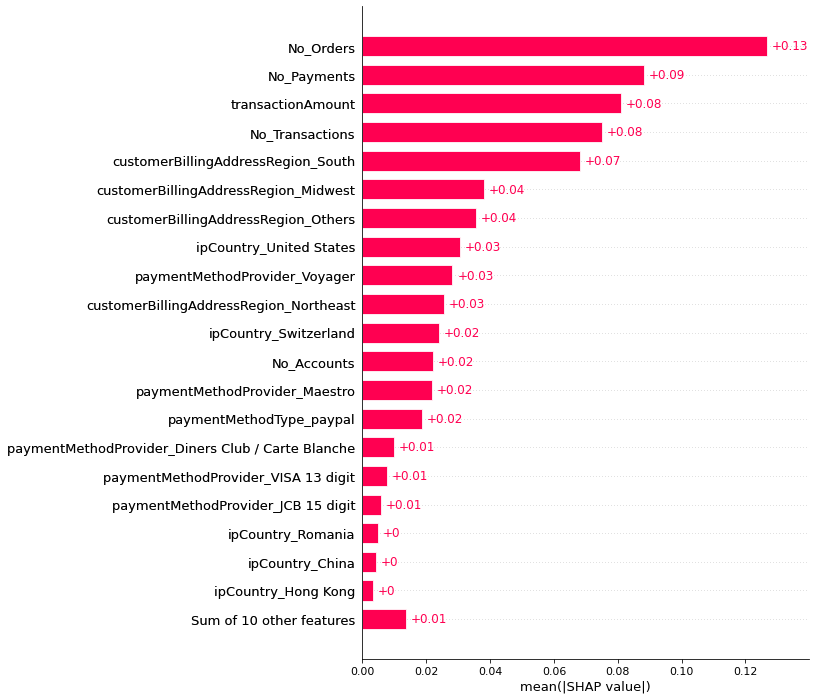

In [48]:
shap.plots.bar(shap_values, max_display = 21)

## **SHAP: Beeswarm plot**

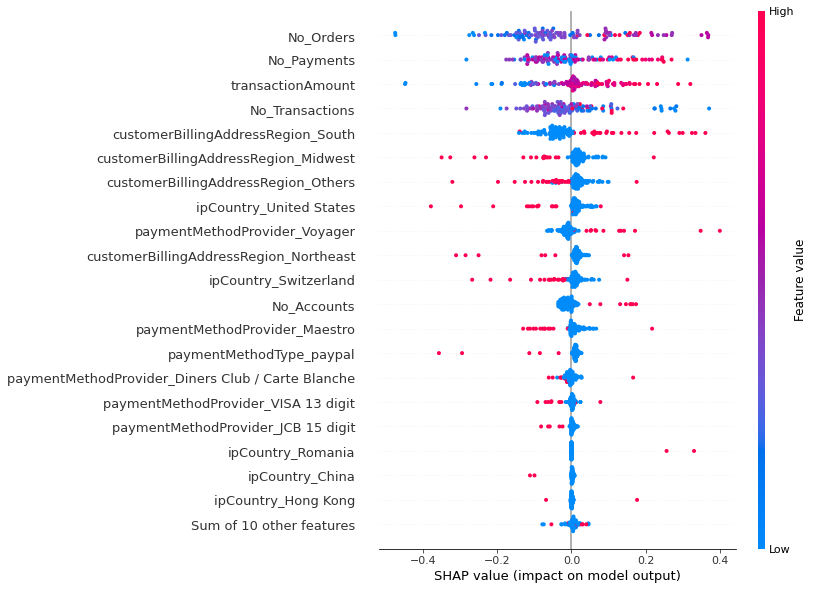

In [49]:
shap.plots.beeswarm(shap_values, max_display = 21)

## **SHAP: Waterfall plot for single observation**

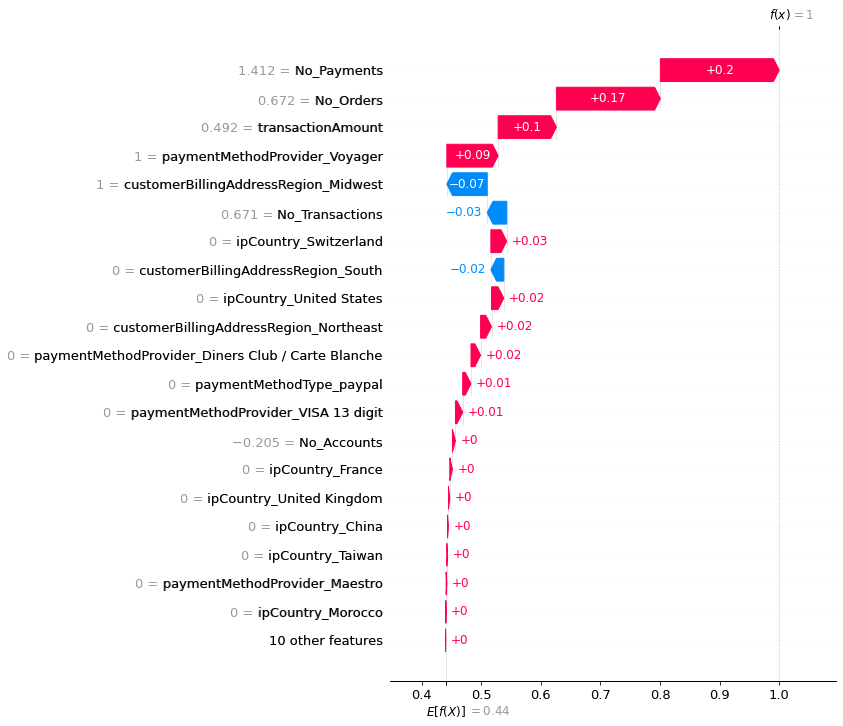

In [50]:
shap.plots.waterfall(shap_values[0], max_display=21)